In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from umap import UMAP
from bertopic import BERTopic
import hdbscan
import re

In [8]:
!pip install tbb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [3]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
import os
os.environ["NUMBA_THREADING_LAYER"] = "tbb"
os.environ["MKL_THREADING_LAYER"] = "tbb"


In [4]:
class ProductGroupGenerator:
    def __init__(self, min_cluster_size=5, max_clusters=82):
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.tfidf = TfidfVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.min_cluster_size = min_cluster_size
        self.max_clusters = max_clusters
        
    def preprocess_text(self, text):
        # Convert to lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text).lower())
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
        
    def generate_clusters(self, texts, method='combined', n_clusters=None):
        """
        Generate product clusters using different methods
        
        Args:
            texts: List of product titles/descriptions
            method: One of 'tfidf_kmeans', 'bert_topic', or 'combined'
            n_clusters: Optional target number of clusters
        """
        if n_clusters is None:
            n_clusters = min(len(texts) // self.min_cluster_size, self.max_clusters)
            
        processed_texts = [self.preprocess_text(text) for text in texts]
        
        if method == 'tfidf_kmeans':
            return self._cluster_tfidf_kmeans(processed_texts, n_clusters)
        elif method == 'bert_topic':
            return self._cluster_bert_topic(processed_texts)
        elif method == 'combined':
            return self._cluster_combined(processed_texts, n_clusters)
        else:
            raise ValueError("Invalid clustering method")
    
    def _cluster_tfidf_kmeans(self, texts, n_clusters):
        # Transform texts to TF-IDF vectors
        tfidf_matrix = self.tfidf.fit_transform(texts)
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(tfidf_matrix)
        
        # Get top terms for each cluster
        cluster_terms = {}
        feature_names = self.tfidf.get_feature_names_out()
        for i in range(n_clusters):
            center_indices = kmeans.cluster_centers_[i].argsort()[::-1][:5]
            cluster_terms[i] = [feature_names[idx] for idx in center_indices]
            
        return labels, cluster_terms
    
    def _cluster_bert_topic(self, texts):
        # Create embeddings
        embeddings = self.sentence_model.encode(texts)
        
        # Initialize BERTopic
        topic_model = BERTopic(
            umap_model=UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'),
            hdbscan_model=hdbscan.HDBSCAN(
                min_cluster_size=self.min_cluster_size,
                min_samples=1,
                metric='euclidean',
                cluster_selection_method='eom'
            ),
            verbose=True
        )
        
        # Fit the model and get topics
        labels, _ = topic_model.fit_transform(texts, embeddings)
        
        # Get topic terms
        topic_terms = {}
        for topic_idx, words in topic_model.get_topics().items():
            topic_terms[topic_idx] = [word[0] for word in words[:5]]
            
        return labels, topic_terms
    
    def _cluster_combined(self, texts, n_clusters):
        # Get clusters from both methods
        print("CLUSTERING BY KMEANS")
        kmeans_labels, kmeans_terms = self._cluster_tfidf_kmeans(texts, n_clusters)
        print("CLUSTERING BY BERT")
        bert_labels, bert_terms = self._cluster_bert_topic(texts)
        
        # Create ensemble clustering
        # Convert labels to one-hot encoding
        def one_hot_encode(labels):
            n_unique = len(np.unique(labels))
            return np.eye(n_unique)[labels]
        
        kmeans_oh = one_hot_encode(kmeans_labels)
        bert_oh = one_hot_encode(bert_labels)
        
        # Concatenate features
        combined_features = np.hstack([kmeans_oh, bert_oh])
        
        # Final clustering on combined features
        print("CREATING FINAL CLUSTERING COMBINATION")
        final_kmeans = KMeans(n_clusters=n_clusters)
        final_labels = final_kmeans.fit_predict(combined_features)
        
        # Combine terms from both methods for final clusters
        final_terms = {}
        for i in range(n_clusters):
            terms_set = set()
            terms_set.update(kmeans_terms.get(i, []))
            terms_set.update(bert_terms.get(i, []))
            final_terms[i] = list(terms_set)[:5]
            
        return final_labels, final_terms

    def analyze_clusters(self, texts, labels, cluster_terms):
        """
        Analyze cluster quality and characteristics
        """
        cluster_stats = {}
        unique_labels = np.unique(labels)
        
        for label in unique_labels:
            cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == label]
            cluster_stats[label] = {
                'size': len(cluster_texts),
                'terms': cluster_terms.get(label, []),
                'sample_products': cluster_texts[:3]  # Show 3 example products
            }
            
        return cluster_stats

In [5]:
# Prepare your data
products_df = pd.read_csv('pet_supplies_cleaned.csv')
texts = products_df['title'] + ' ' + products_df['description']

In [6]:
# Initialize clustering class
generator = ProductGroupGenerator(min_cluster_size=50, max_clusters = 200)

In [7]:
# Run clustering
labels, cluster_terms = generator.generate_clusters(texts, method='combined')

CLUSTERING BY KMEANS


/Users/rithwikn/new_env/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning:


Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md




CLUSTERING BY BERT


2025-02-04 12:09:19,393 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
/Users/rithwikn/new_env/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning:

The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.



ValueError: No threading layer could be loaded.
HINT:
Intel TBB is required, try:
$ conda/pip install tbb

In [6]:
# Analyze the clusters
cluster_stats = generator.analyze_clusters(texts, labels, cluster_terms)

NameError: name 'labels' is not defined

In [9]:
# Number of total products
products_df.shape[0] 

16471

In [10]:
# Number of clusters
len(cluster_stats)

200

In [20]:
# Sample of group sizes and key terms
for i in range(10):
    print(f"Cluster Size: {cluster_stats[i]['size']}")
    print(f"Key Terms: {', '.join(cluster_stats[i]['terms'])}\n")

Cluster Size: 146
Key Terms: led, light, motion, night light, night

Cluster Size: 22
Key Terms: outdoor, camping, string, string lights, flashlights

Cluster Size: 15
Key Terms: filter, particles, head, pressure, air

Cluster Size: 53
Key Terms: outdoor, garden, pathway, bottle, pump

Cluster Size: 116
Key Terms: fixture, outdoor, ceiling, string, christmas

Cluster Size: 164
Key Terms: tool, string, speed, battery, panel

Cluster Size: 148
Key Terms: keys, hex, screwdriver, lock, locks

Cluster Size: 78
Key Terms: projector, glove, vest, gloves, colors

Cluster Size: 38
Key Terms: magnetic, filter, screen, water, door

Cluster Size: 140
Key Terms: usb, ports, led, light, light bulbs



In [11]:
num_items = []

for cluster in cluster_stats.keys():
    num_items.append(cluster_stats[cluster]['size'])

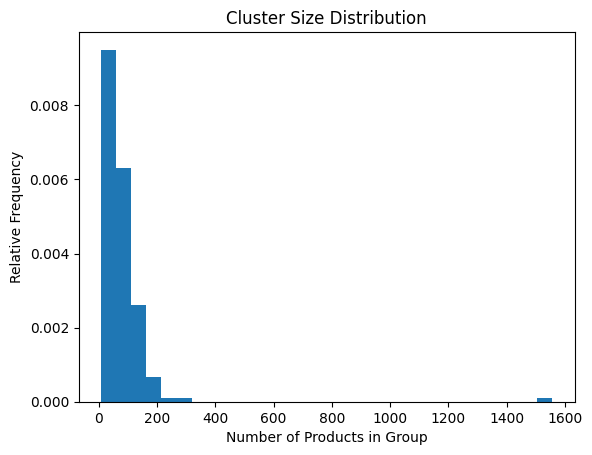

In [28]:
plt.hist(num_items, bins=30, density=True)
plt.title("Cluster Size Distribution")
plt.xlabel("Number of Products in Group")
plt.ylabel("Relative Frequency")
plt.show()

In [32]:
products_df['label'] = labels
products_df['label'].value_counts()[:5]

In [34]:
# Largest Group Info
cluster_stats[134]

{'size': 1556,
 'terms': ['durable', 'plastic', 'easy', 'use', 'product'],
 'sample_products': ['K&J Premium 4ft Stainless Steel Washing Machine Hoses Burst Proof 2 Pack - Hot and Cold Water Supply Hoses for Washing Machines CONTENTS Included in this package are two 4ft stainless steel washing machine hoses suitable for both hot and cold water supply The extrathick internal rubber washers prevent leaks from ever developing INSTALLATION IS A BREEZE 1 Make sure supply taps are turned OFF 2 Remove old hoses from supply taps 3 Handtighten your new supply hoses onto the supply taps Then give another  turn each with a pair of pliers 4 Handtighten the other end of your new supply hoses onto the corresponding inlets on your washer hot to hot cold to cold Then give another  turn each with a pair of pliers 5 Turn on supply taps and check for leaks at all connections DONE Enjoy years and years of hasslefree service These hoses will outlast your washing machine  and the next one  Two 4 Stainless S

In [37]:
products_df.to_csv("data/labeled_tools_and_home_improvement_products.csv", index=False)